# Movie Revenue Analysis


## About the data

This data set (https://www.kaggle.com/narmelan/top-ten-blockbusters-20191977) contains details on top ten worldwide best performing movies from the year 1977 to 2019. 

The list of features are as follows:

1. release_year: Year on which the movie was released
2. rankinyear: Rank of the movie in the given year
3. imdb_rating: Rating for the movie on IMDB
4. mpaa_rating: Motion picture rating
5. film_title: Name of the movie
6. film_budget: Budget in dollars
7. lengthinmin: Length of the movie in minutes
8. domestic_distributor: Agency/company that distributed the movie domestically
9. worldwide_gross: Worldwide gross revenue in dollars
10. domestic_gross: Domestic gross revenue in dollars
11. genre_1: Genre i.e. type of the movie e.g. horror, drama, etc.
12. genre_2: Other genre
13. genre_3: Other genre

The data is in a csv file. Let us load the data and peak into it.


In [272]:
# Import necessary packages.
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('Blockbusters_2019-1977.csv')

The dataset contains 430 observations and 13 features. Following list contains the data type of each feature.

In [273]:
data.dtypes

release_year              int64
rank_in_year              int64
imdb_rating             float64
mpaa_rating              object
film_title               object
film_budget               int64
length_in_min             int64
domestic_distributor     object
worldwide_gross           int64
domestic_gross            int64
genre_1                  object
genre_2                  object
genre_3                  object
dtype: object

It is clear that we have categorical features. They will have to be coded using one hot encoding.

Here are summary statistics for some selected variables.

In [274]:
display(pd.DataFrame(data.worldwide_gross.describe()))

,worldwide_gross
count,4.300000e+02
mean,4.993737e+08
std,3.966114e+08
min,3.718714e+07
25%,2.155117e+08
50%,3.800620e+08
75%,7.317081e+08
max,2.797801e+09


The unique levels of the categorical variable *mpaa_rating*. Note that this contain *NaN* which needs to be fixed.

In [275]:
pd.DataFrame(data.mpaa_rating.unique())

,0
0,PG-13
1,PG
2,G
3,R
4,NaN


The number of unique *domestic_distributor* levels are given below.

In [276]:
data.domestic_distributor.nunique()

25

-----------

## Objectives

The following list denotes the objectives for this project.

1. Data cleaning and preprocessing: Identifying limitations of data and fixing them.
2. Clustering: Attempting to cluster data using three methods.
3. Summary: Key finds and summary.
4. Suggestions: Suggestions for further analysis.

## Data Cleaning  and Preprocessing

### Missing values

This data set is in a quite clean state. Let us start by looking for missing values.

In [277]:
data.isna().sum()

release_year              0
rank_in_year              0
imdb_rating               0
mpaa_rating               1
film_title                0
film_budget               0
length_in_min             0
domestic_distributor      0
worldwide_gross           0
domestic_gross            0
genre_1                   0
genre_2                  21
genre_3                 106
dtype: int64

We can see that there is one *mpaa_rating* value missing. There are also 21 and 106 *genre_2* and *genre_3* values missing. Let us look at which movie is missing the *mpaa_rating* feature.

In [278]:
data[data.mpaa_rating.isna()].film_title

26    Wolf Warrior 2
Name: film_title, dtype: object

IMDB states that this movie is unrated. We can either create a new level "NR" for this movie or just delete this row. I believe if we create a new level, it would introduce an artificial effect on the data because this level will only be used by this single observation. Therefore, dropping this level is the best.

In [279]:
data.drop(index=26, inplace=True)

The absense of values in *genre_2* and *genre_3* columns are not problematic, because I do not intend to use those variables in the present study. The feature *genre_1* contains no missing values and therefore, good enough for analysis. This value contains the major genre of the movie.

Therefore, let us drop these two columns.

In [280]:
data.drop(columns=['genre_2', 'genre_3'], inplace=True)

Let us convert the dollar values into millions of dollars and round to two decimal points. This makes it easier to work with those values.

In [281]:
data["film_budget"] = data.film_budget.div(1000000).round(2)
data["worldwide_gross"] = data.worldwide_gross.div(1000000).round(2)
data["domestic_gross"] = data.domestic_gross.div(1000000).round(2)


### Skewness

Let us now look at the skewness of the data. If features are skewed, they need to be log transformed.

In [282]:
skews = data.skew()
skews[skews > .75]

film_budget        0.769425
worldwide_gross    1.693160
domestic_gross     1.692143
dtype: float64

We can see that above three features have skewed values. We can look at the following graphs to get a visual idea.

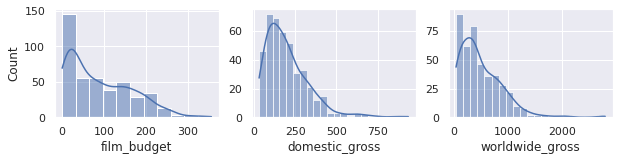

In [283]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')

fig, ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(2)

sns.histplot(data.film_budget, kde=True, label='All values', ax=ax[0])
sns.histplot(data.domestic_gross, kde=True, label='b', ax = ax[1]).set(ylabel='')
sns.histplot(data.worldwide_gross, kde=True, label='b', ax = ax[2]).set(ylabel='');

We find that all these variables are right skewed, and therefore, need to be **log transformed**.

In [284]:
data.film_budget = data.film_budget.apply(np.log1p)
data.worldwide_gross = data.worldwide_gross.apply(np.log1p)
data.domestic_gross = data.domestic_gross.apply(np.log1p)

### Linear relationships and multicollinearity

Let us look at pairwise correlations between the numerical features.

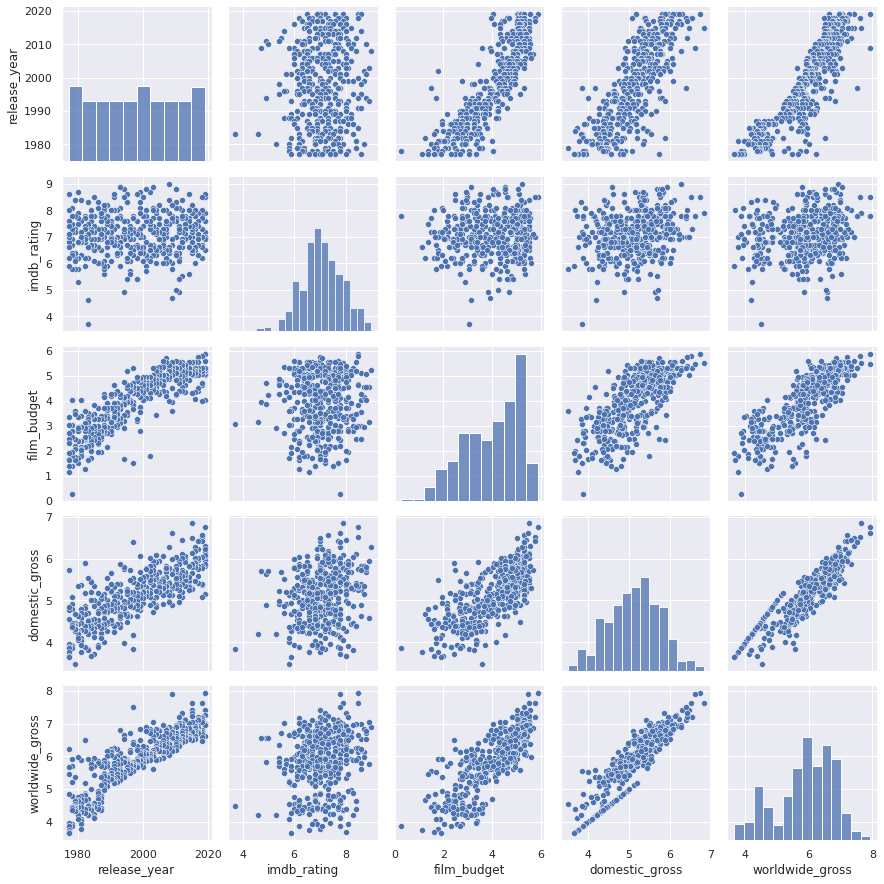

In [285]:
sns.pairplot(data, vars=['release_year', 'imdb_rating', 'film_budget', 
                         'domestic_gross', 'worldwide_gross']);

We can see that many variables such as *worldwide_gross*, *release_year*, *film_budget*, and *domestic_gross* are collinear.

Therefore, we can state that there is some redundancy between some features in the data set. We should be able to reduce dimensionality of the data using an appropriate method.

### Categorical features


The feature *film_title* is unique for each movie, and therefore, is useless to use in modeling. We need to drop it.

In [286]:
data.drop(columns = ['film_title'], inplace = True)


The following features are categorical and therefore, their levels need to be encoded into numerical features.

In [287]:
mask = data.dtypes == np.object
cat_cols = list(data.columns[mask])
', '.join(cat_cols)

'mpaa_rating, domestic_distributor, genre_1'


Carry out one hot encoding.

In [288]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
ohe = OneHotEncoder(drop = 'first')


for col in cat_cols:

    # Label transform. String levels of 'col' -> int levels.
    # dat is (num_rows, ) numpy array.
    dat = le.fit_transform(data[col]).astype(np.int)
    
    # Remove the original column from data frame.
    data = data.drop(col, axis=1)
    
    # One hot encode the data.
    # dat2 is a sparse matrix.
    dat2 = ohe.fit_transform(dat.reshape(-1,1))
    
    # Create new column names.
    n_cols = dat2.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
    
    # Combine to create new data frame.
    dfnew = pd.DataFrame(dat2.toarray(), index = data.index, columns = col_names)

    data = pd.concat([data, dfnew], axis = 1)


### Scaling

Scale the data using min max scaling method, so that all the features are in the same scale.

In [289]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in data.columns:
    data[col] = mms.fit_transform(data[[col]]).squeeze()


## Clustering

We will attempt the following three methods for clustering the data

1. K-means
2. Hierarchical aglomerative clustering
3. DBSCAN

### K-means method

Let us start by tuning hyper parameter *num_clusters* using the inertia as the metric.

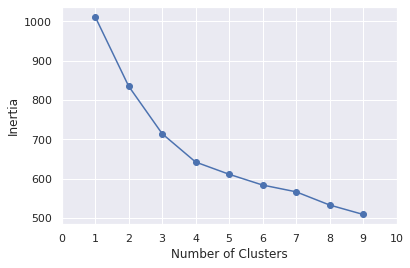

In [290]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

inertia = []
num_clusters = list(range(1, 10, 1))

for k in num_clusters:
    km = KMeans(n_clusters=k)
    km.fit(data)
    inertia.append(km.inertia_)
    
plt.plot(num_clusters, inertia)
plt.scatter(num_clusters, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.xticks(np.arange(0, 11, 1));


If we consider the elbow position as the point where the maximum change in slope occurs, we can see that *num_clusters* = 4 is the elbow position. Therefore, 4 is the best number of clusters for this data set.

Let us carry out clustering with *num_clusters* = 4 and observe the outcome.

In [291]:
km = KMeans(n_clusters=4)
km.fit(data)

KMeans(n_clusters=4)

In [292]:
print('Maximum no. of iterations: {:d} \nUsed no. of iterations: {:d}'.
      format(km.max_iter, km.n_iter_))

Maximum no. of iterations: 300 
Used no. of iterations: 4



It is clear that out of the maximum 300 of iterations, our model needed only 4. Therefore, we can state that the algorithm converged.

We can look at which observations (row) belong to which cluster as follows. Only the first 20 observations are given. The numbers 0, 2, 3 represent the cluster numbers.

In [293]:
km.labels_[0:20]

array([1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1],
      dtype=int32)

### Hierarchical aglomerative clustering method

In [294]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=4, linkage='ward', compute_full_tree=True)
ag = ag.fit(data)


We can see which data points below to which cluster like below.

In [295]:
ag.labels_[0:20] # Only the first 20.

array([0, 3, 3, 0, 0, 3, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0])

### DBSCAN method

In [296]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.5, min_samples=2)
db.fit(data)

DBSCAN(min_samples=2)


Let us look at the number of outliers found by the algorithm. These have the label -1.

In [297]:
len(db.labels_[db.labels_<0])

118


This is a high number of outliers, given the total number of rows of 429.

### Principal Component Analysis

Let us now try to carry out PCA and reduce dimensionality.

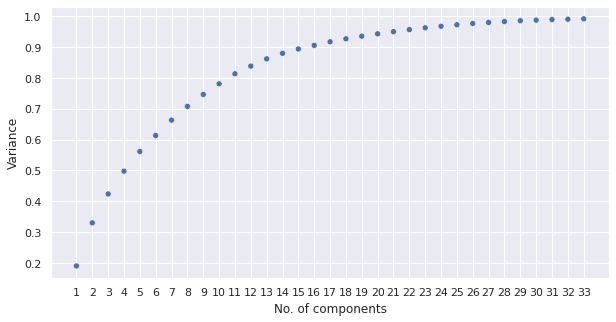

In [298]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

for n in range(1, 34):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')

ax = sns.scatterplot(data=pca_df, legend=False)
ax.set_ylabel('Variance')
ax.set_xlabel('No. of components')
ax.set_xticks(np.arange(1, 34, 1));

matplotlib.pyplot.gcf().set_size_inches(10,5)

We can see that we can reduce the number of dimensions to about 32 and still retain the variance of the original data set.

## Summary

K-means method resulted in an ideal cluster size of 4. Using the DBSCAN method resulted in a lot of outliers that was quite worrying. This makes it advisable to look at the data set closely to make sure that the quality of the data is good. A larger data set with much higher number of observations might have resulted in better clustering performance. Finally, PCA (linear) examination outcomes state that the dimensionality of the original data(44) can be reduced to around 32 while retaining more that 99% of the original variance.


## Suggestions

A higher number of data observations would be ideal. The current set only contains about 44. Furthermore, more thorough analysis should be conducted to uncover hidden structures of the data (especialy w.r.t. the DBSCAN method). Clustering on reduced dimensional data should be attempted. Hyper parameter tuning on clustering would result in better parameters than used.